### Link predication with Word2vec method

How does the individual embedding looks like so far after walking on the directed graphs?

In [1]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from stellargraph import StellarDiGraph
from cell import utils, plot_utils, analysis, graph_utils
from cell.Word2vec import prepare_vocab, dataloader, wv

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/fahimehb/anaconda3/envs/py374/lib

In [2]:
import imp
from cell import  utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(plot_utils)
imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [3]:
length = 10000
p = 1
q = 1
N = 1
batch_size = 2000
walk_filename = "walk_node21_32_removed.csv"
roi = "VISp"
project_name = "NPP_GNN_project"
layer_class = "single_layer"
layer = "base_unnormalized_allcombined"
walk_type= "Directed_Weighted_node2vec"

walk_dir = utils.get_walk_dir(roi,
                              project_name, 
                              N, 
                              length, 
                              p, 
                              q, 
                              layer_class, 
                              layer, 
                              walk_type) 

In [4]:
corpus = utils.read_list_of_lists_from_csv(os.path.join(walk_dir, walk_filename))
vocabulary = prepare_vocab.get_vocabulary(corpus)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=True)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=True)

new_tuples = prepare_vocab.MCBOW_get_word_context_tuples(corpus=corpus, window=2)

dataset = dataloader.MCBOW_WalkDataset(new_tuples, word_2_index)

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          batch_size=2000, 
                                          shuffle=False,
                                          num_workers=1)

examples = iter(data_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

lenght of vocabulary: 91
a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero
MCBOW by default adds a padding node called pad with index zero
There are 910000 pairs of target and context words
torch.Size([2000]) torch.Size([2000, 4])


In [5]:
# new_tuples[-10:]

In [6]:
# dataset.context_list[-10:]

In [7]:
# dataset.target[-10:]

In [8]:
# [index_2_word[i] for i in dataset.context_list[-10:][9].numpy()]

In [9]:
# edgelist_dir = utils.get_edgelist_dir(roi,
#                                       project_name,
#                                       layer) 
# # print(edgelist_dir)
# edgelist_filename = "selfconnection_added_edges_node21_32_removed.csv"

# tmp_edge = pd.read_csv(os.path.join(edgelist_dir, edgelist_filename), index_col="Unnamed: 0")
# tmp_edge[['source', 'target']] = tmp_edge[['source', 'target']].astype(str)

# # # 1) for each layer first create a nx-Digraph
# nxg = graph_utils.build_nx_graph(source_target_weight=tmp_edge, directed=True)

# # # 2) Create stellar Di graphs
# sdg = StellarDiGraph(nxg)

In [10]:
# len(sdg.edges())

In [11]:
# edges = []
# for corp in corpus:
#     edges = edges + [(corp[i], corp[i+1]) for i in range(len(corp)-1)]
# edges = set(edges)

In [30]:
len(sdg.nodes())

91

In [12]:
vocab_size = len(vocabulary) + 1 
embedding_size = 2
learning_rate = 0.001
n_epochs = 20

In [13]:
criterion = nn.CrossEntropyLoss()

model = wv.MCBOW_Word2Vec(embedding_size=embedding_size, vocab_size=vocab_size)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
n_total_steps = len(data_loader)

training_loss = []

for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        prediction = model(context)
        loss = criterion(prediction, target)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    t1 = time.time()
    print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

the index2word and word2index dicts must have padding with index zero
time is 17.49
epoch: 1/20, loss:114.7162
time is 18.67
epoch: 2/20, loss:19.3893
time is 16.28
epoch: 3/20, loss:4.9377
time is 20.33
epoch: 4/20, loss:4.5833
time is 22.64
epoch: 5/20, loss:4.5304
time is 26.21
epoch: 6/20, loss:4.4760
time is 16.28
epoch: 7/20, loss:4.4612
time is 17.10
epoch: 8/20, loss:4.4618
time is 16.71
epoch: 9/20, loss:4.4623
time is 17.56
epoch: 10/20, loss:4.4626
time is 18.43
epoch: 11/20, loss:4.4629
time is 18.91
epoch: 12/20, loss:4.4630
time is 21.53
epoch: 13/20, loss:4.4632
time is 18.70
epoch: 14/20, loss:4.4632
time is 26.72
epoch: 15/20, loss:4.4632
time is 29.16
epoch: 16/20, loss:4.4632
time is 15.01
epoch: 17/20, loss:4.4630
time is 14.71
epoch: 18/20, loss:4.4627
time is 14.75
epoch: 19/20, loss:4.4623
time is 14.58
epoch: 20/20, loss:4.4615


In [22]:
context

tensor([[49,  8, 21, 27],
        [16, 86, 77, 84],
        [45, 79, 60, 42],
        ...,
        [15, 10,  8, 37],
        [21, 29, 27, 19],
        [22, 40, 50, 36]])

In [21]:
target

tensor([80, 78,  4,  ..., 22, 78, 73])

In [18]:
target[0]

tensor(80)

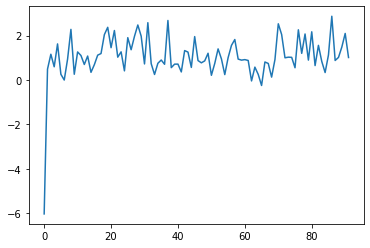

In [55]:
plt.plot(prediction[0].detach().numpy())

In [13]:
sm = nn.LogSoftmax(dim=1)
nnl = nn.CrossEntropyLoss()
print(sm(prediction[9:10])[0][target[9:10].numpy()[0]])
print(nnl(prediction[9:10], target[9:10]))

tensor(-4.5914, grad_fn=<SelectBackward>)
tensor(4.5914, grad_fn=<NllLossBackward>)


In [14]:
sm(prediction[0:1])

tensor([[-11.9140,  -5.3979,  -4.7286,  -5.2923,  -4.2635,  -5.6312,  -5.8892,
          -4.9472,  -3.6094,  -5.6293,  -4.6252,  -4.7857,  -5.1892,  -4.8099,
          -5.5416,  -5.1988,  -4.7696,  -4.6967,  -3.8450,  -3.5163,  -4.4332,
          -3.6606,  -4.8595,  -4.6202,  -5.4762,  -3.9822,  -4.5253,  -3.9221,
          -3.4117,  -3.9117,  -5.1643,  -3.3081,  -5.1527,  -5.6388,  -5.1350,
          -4.9884,  -5.1800,  -3.2089,  -5.3315,  -5.1744,  -5.1723,  -5.5241,
          -4.5632,  -4.6316,  -5.3211,  -3.9338,  -5.0134,  -5.1140,  -5.0270,
          -4.6838,  -5.6759,  -5.1419,  -4.4877,  -4.9382,  -5.6440,  -4.8792,
          -4.3296,  -4.0656,  -4.9463,  -4.9932,  -4.9702,  -5.0086,  -5.9291,
          -5.3082,  -5.6361,  -6.1340,  -5.0767,  -5.1428,  -5.7576,  -4.9683,
          -3.3580,  -3.8405,  -4.8878,  -4.8603,  -4.8673,  -5.3361,  -3.6285,
          -4.6880,  -3.8167,  -4.9916,  -3.7187,  -5.2384,  -4.3287,  -5.0533,
          -5.5518,  -4.7597,  -3.0183,  -5.0083,  -4

In [19]:
13*7

91

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


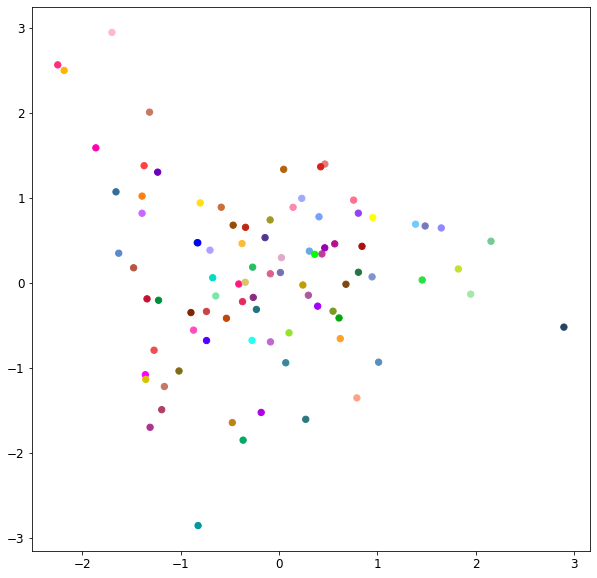

In [14]:
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
vectors = vectors[1:]
idx = [i for i in index_2_word.values()][1:]
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = idx,
                                                 ndim=2, 
                                                 cl_df=cldf,
                               padding_label = "0")
# data['Z1'] = -1 * data["Z1"]
#data['Z0'] = -1 * data["Z0"]

fig = plot_utils.plot_embedding(data=data, 
                          cl_df=cldf,
                          plot_dim=2, 
                          plot_size=(10,10), 
                          annotation=False)

In [ ]:
def split_train_test_validation(g):
    eids = np.random.permutation(g.number_of_edges())
    train_eids = eids[:int(len(eids) * 0.8)]
    valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
    test_eids = eids[int(len(eids) * 0.9):]
    train_g = g.edge_subgraph(train_eids, preserve_nodes=True)
    return train_eids, valid_eids, test_eids, train_g